In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
"""from improved_autoencoder import (
    create_improved_autoencoder,
    train_improved_autoencoder,
    evaluate_autoencoder,
    plot_training_history,
    plot_reconstruction_errors,
    experiment_with_architectures,
    run_improved_autoencoder_pipeline
)
"""

ModuleNotFoundError: No module named 'improved_autoencoder'

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def create_improved_autoencoder(input_dim, architecture_type="deep"):
    """
    Improved autoencoder with multiple architecture options

    Args:
        input_dim: Input dimension (14 for your case)
        architecture_type: "shallow", "medium", "deep", or "very_deep"
    """

    if architecture_type == "shallow":
        # Original architecture (for comparison)
        encoder_dims = [8]
        bottleneck_dim = 3

    elif architecture_type == "medium":
        # Medium depth
        encoder_dims = [16, 8]
        bottleneck_dim = 4

    elif architecture_type == "deep":
        # Recommended deep architecture
        encoder_dims = [32, 16]
        bottleneck_dim = 4

    elif architecture_type == "very_deep":
        # Very deep architecture
        encoder_dims = [64, 32, 16]
        bottleneck_dim = 6

    # Input layer
    input_layer = layers.Input(shape=(input_dim,), name='input')

    # Encoder
    x = input_layer
    for i, dim in enumerate(encoder_dims):
        x = layers.Dense(dim, name=f'encoder_dense_{i+1}')(x)
        x = layers.BatchNormalization(name=f'encoder_bn_{i+1}')(x)
        x = layers.Activation('relu', name=f'encoder_relu_{i+1}')(x)
        x = layers.Dropout(0.2, name=f'encoder_dropout_{i+1}')(x)

    # Bottleneck
    bottleneck = layers.Dense(bottleneck_dim, activation='relu', name='bottleneck')(x)

    # Decoder (mirror of encoder)
    x = bottleneck
    decoder_dims = encoder_dims[::-1]  # Reverse encoder dimensions

    for i, dim in enumerate(decoder_dims):
        x = layers.Dense(dim, name=f'decoder_dense_{i+1}')(x)
        x = layers.BatchNormalization(name=f'decoder_bn_{i+1}')(x)
        x = layers.Activation('relu', name=f'decoder_relu_{i+1}')(x)
        x = layers.Dropout(0.2, name=f'decoder_dropout_{i+1}')(x)

    # Output layer (no activation for reconstruction)
    output_layer = layers.Dense(input_dim, activation='linear', name='output')(x)

    # Create model
    autoencoder = models.Model(inputs=input_layer, outputs=output_layer, name=f'autoencoder_{architecture_type}')

    return autoencoder

def huber_loss(y_true, y_pred, delta=1.0):
    """Huber loss function - robust to outliers"""
    error = y_true - y_pred
    condition = tf.abs(error) <= delta
    squared_loss = 0.5 * tf.square(error)
    linear_loss = delta * tf.abs(error) - 0.5 * tf.square(delta)
    return tf.where(condition, squared_loss, linear_loss)

def train_improved_autoencoder(X_train_split, X_val_split,
                             architecture_type="deep",
                             loss_function="mse",
                             learning_rate=0.001,
                             batch_size=1024,
                             max_epochs=100):
    """
    Train improved autoencoder with advanced techniques
    """

    input_dim = X_train_split.shape[1]

    # Create model
    autoencoder = create_improved_autoencoder(input_dim, architecture_type)

    # Choose loss function
    if loss_function == "mse":
        loss = "mse"
    elif loss_function == "mae":
        loss = "mae"
    elif loss_function == "huber":
        loss = lambda y_true, y_pred: huber_loss(y_true, y_pred, delta=1.0)

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # Train model
    print(f"Training {architecture_type} autoencoder with {loss_function} loss...")
    autoencoder.summary()

    history = autoencoder.fit(
        X_train_split, X_train_split,
        validation_data=(X_val_split, X_val_split),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        shuffle=True,
        verbose=1
    )

    return autoencoder, history

def evaluate_autoencoder(autoencoder, X_normal_scaled, X_fraud_scaled, threshold_percentile=95):
    """
    Comprehensive evaluation of autoencoder performance
    """

    print("Evaluating autoencoder performance...")

    # Get reconstructions
    recon_normal = autoencoder.predict(X_normal_scaled, batch_size=4096, verbose=0)
    recon_fraud = autoencoder.predict(X_fraud_scaled, batch_size=4096, verbose=0)

    # Calculate reconstruction errors (MSE)
    mse_normal = np.mean(np.square(X_normal_scaled - recon_normal), axis=1)
    mse_fraud = np.mean(np.square(X_fraud_scaled - recon_fraud), axis=1)

    print(f"Normal mean MSE: {np.mean(mse_normal):.6f}")
    print(f"Fraud mean MSE: {np.mean(mse_fraud):.6f}")
    print(f"MSE Ratio (Fraud/Normal): {np.mean(mse_fraud)/np.mean(mse_normal):.3f}")

    # Calculate AUC
    y_true = np.concatenate([np.zeros(len(mse_normal)), np.ones(len(mse_fraud))])
    y_scores = np.concatenate([mse_normal, mse_fraud])

    auc_score = roc_auc_score(y_true, y_scores)
    print(f"AUC Score: {auc_score:.4f}")

    # Set threshold based on normal data percentile
    threshold = np.percentile(mse_normal, threshold_percentile)
    print(f"Threshold ({threshold_percentile}th percentile): {threshold:.6f}")

    # Calculate precision and recall
    normal_anomalies = np.sum(mse_normal > threshold)
    fraud_detected = np.sum(mse_fraud > threshold)

    precision = fraud_detected / (fraud_detected + normal_anomalies) if (fraud_detected + normal_anomalies) > 0 else 0
    recall = fraud_detected / len(mse_fraud) if len(mse_fraud) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Normal flagged as anomaly: {normal_anomalies}/{len(mse_normal)} ({100*normal_anomalies/len(mse_normal):.2f}%)")
    print(f"Fraud detected: {fraud_detected}/{len(mse_fraud)} ({100*fraud_detected/len(mse_fraud):.2f}%)")

    return {
        'auc_score': auc_score,
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'mse_normal': mse_normal,
        'mse_fraud': mse_fraud
    }

def plot_training_history(history):
    """Plot training and validation loss"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_reconstruction_errors(mse_normal, mse_fraud):
    """Plot distribution of reconstruction errors"""
    plt.figure(figsize=(10, 6))

    plt.hist(mse_normal, bins=100, alpha=0.7, label='Normal', density=True)
    plt.hist(mse_fraud, bins=100, alpha=0.7, label='Fraud', density=True)
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()
    plt.yscale('log')
    plt.show()

def experiment_with_architectures(X_train_split, X_val_split, X_normal_scaled, X_fraud_scaled):
    """
    Experiment with different architectures and loss functions
    """

    results = {}

    architectures = ["shallow", "medium", "deep", "very_deep"]
    loss_functions = ["mse", "mae", "huber"]

    for arch in architectures:
        for loss_func in loss_functions:
            print(f"\n{'='*50}")
            print(f"Testing {arch} architecture with {loss_func} loss")
            print(f"{'='*50}")

            try:
                # Train model
                autoencoder, history = train_improved_autoencoder(
                    X_train_split, X_val_split,
                    architecture_type=arch,
                    loss_function=loss_func,
                    max_epochs=100
                )

                # Evaluate model
                eval_results = evaluate_autoencoder(autoencoder, X_normal_scaled, X_fraud_scaled)

                # Store results
                key = f"{arch}_{loss_func}"
                results[key] = {
                    'model': autoencoder,
                    'history': history,
                    'evaluation': eval_results
                }

                print(f"✅ {key}: AUC = {eval_results['auc_score']:.4f}")

            except Exception as e:
                print(f"❌ {key}: Failed with error: {str(e)}")

    # Find best model
    best_key = max(results.keys(), key=lambda k: results[k]['evaluation']['auc_score'])
    best_auc = results[best_key]['evaluation']['auc_score']

    print(f"\n🏆 Best model: {best_key} with AUC = {best_auc:.4f}")

    return results, best_key

# Example usage function
def run_improved_autoencoder_pipeline(X_normal_scaled, X_fraud_scaled, sample_size=1_000_000):
    """
    Complete pipeline with improved autoencoder
    """

    print("🚀 Starting Improved Autoencoder Pipeline")

    # Sample training data if needed
    if X_normal_scaled.shape[0] > sample_size:
        idx = np.random.choice(X_normal_scaled.shape[0], sample_size, replace=False)
        X_train = X_normal_scaled[idx]
    else:
        X_train = X_normal_scaled

    print(f"Training sample: {X_train.shape}")

    # Train-validation split
    X_train_split, X_val_split = train_test_split(
        X_train, test_size=0.1, random_state=42
    )

    print(f"Train: {X_train_split.shape}, Val: {X_val_split.shape}")

    # Quick test with best configuration
    print("\n🎯 Training with recommended configuration...")
    autoencoder, history = train_improved_autoencoder(
        X_train_split, X_val_split,
        architecture_type="deep",
        loss_function="huber",
        learning_rate=0.001,
        max_epochs=100
    )

    # Evaluate
    results = evaluate_autoencoder(autoencoder, X_normal_scaled, X_fraud_scaled)

    # Plot results
    plot_training_history(history)
    plot_reconstruction_errors(results['mse_normal'], results['mse_fraud'])

    # Run full experiment if AUC is promising
    if results['auc_score'] > 0.6:
        print("\n🧪 AUC looks promising! Running full architecture experiment...")
        all_results, best_key = experiment_with_architectures(
            X_train_split, X_val_split, X_normal_scaled, X_fraud_scaled
        )
        return autoencoder, history, results, all_results, best_key
    else:
        print(f"\n⚠️  AUC still low ({results['auc_score']:.4f}). Check data preprocessing or try different features.")
        return autoencoder, history, results, None, None


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
csv_path = "/content/drive/MyDrive/financial-fraud-dataset-train.csv"

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
df = pd.read_csv(csv_path)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (5000000, 45)


,transaction_id,timestamp,sender_account,receiver_account,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,...,txn_count_last_1h,txn_count_last_24h,total_amount_last_1h,time_since_last,avg_gap_between_txns,merchant_fraud_rate,channel_risk_score,persona_fraud_risk,location_fraud_risk,ip_geo_region
0,T2162315,2023-01-24 09:54:06.198396,1000018177,8385560081,deposit,Local Market Purchase,Aba,mobile,False,NaN,...,1,1,654135.08,0.000000,0.000000,0.1,0.8,0.5,0.1,South East
1,T1764581,2023-02-22 16:16:19.271951,1000018177,5643014197,payment,SPAR Purchase,Onitsha,mobile,False,NaN,...,2,2,687449.11,42142.217893,21071.108946,0.1,0.3,0.5,0.1,South East
2,T3305551,2023-05-04 16:01:42.312142,1000018177,7722691989,withdrawal,Other Transaction,Onitsha,web,False,NaN,...,3,3,719985.77,102225.384003,48122.533965,0.1,0.8,0.5,0.0,South East
3,T174955,2023-05-07 13:15:03.037215,1000018177,4987435115,payment,Ikeja Electric Bill,Benin City,atm,False,NaN,...,4,4,733430.88,4153.345418,37130.236828,0.1,0.3,0.5,0.1,South South
4,T3695059,2023-06-08 11:37:39.155188,1000018177,7939643449,withdrawal,Arik Air Flight,Aba,web,False,NaN,...,5,5,858543.44,45982.601966,38900.709856,0.1,0.6,0.5,0.0,South East


In [ ]:
AE_FEATURES = [
    "amount_ngn",
    "spending_deviation_score",
    "velocity_score",
    "user_avg_txn_amt",
    "user_std_txn_amt",
    "txn_hour",
    "is_night_txn",
    "user_txn_frequency_24h",
    "txn_count_last_1h",
    "avg_gap_between_txns",
    "device_seen_count",
    "is_device_shared",
    "new_device_transaction",
    "geospatial_velocity_anomaly"
]


"""AE_FEATURES = [
    "amount_ngn", "txn_hour", "user_avg_txn_amt",
    "user_txn_frequency_24h", "avg_gap_between_txns"
]"""

missing = [c for c in AE_FEATURES if c not in df.columns]
print("Missing columns:", missing)

Missing columns: []


In [ ]:
normal_df = df[df["is_fraud"] == 0]
fraud_df = df[df["is_fraud"] == 1]

print("Normal:", normal_df.shape)
print("Fraud:", fraud_df.shape)

Normal: (4820447, 45)
Fraud: (179553, 45)


In [ ]:
X_normal = normal_df[AE_FEATURES].copy()
X_fraud = fraud_df[AE_FEATURES].copy()

print(X_normal.shape)

(4820447, 5)


In [ ]:
scaler = StandardScaler()

# Fit only on normal data
X_normal_scaled = scaler.fit_transform(X_normal)

# Transform fraud data
X_fraud_scaled = scaler.transform(X_fraud)

print("Scaled normal shape:", X_normal_scaled.shape)

Scaled normal shape: (4820447, 5)


In [ ]:
sample_size = 1_000_000  # 1M ile başlayalım

if X_normal_scaled.shape[0] > sample_size:
    idx = np.random.choice(X_normal_scaled.shape[0], sample_size, replace=False)
    X_train = X_normal_scaled[idx]
else:
    X_train = X_normal_scaled

print("Training sample:", X_train.shape)

Training sample: (1000000, 5)


In [ ]:
from sklearn.model_selection import train_test_split

X_train_split, X_val_split = train_test_split(
    X_train,
    test_size=0.1,
    random_state=42
)

print("Train:", X_train_split.shape)
print("Val:", X_val_split.shape)

Train: (900000, 5)
Val: (100000, 5)


In [ ]:
# CELL 2: Replace your existing model creation and training cell
# Bu hücre mevcut model tanımlama ve eğitim hücrenizi değiştirecek


print("🚀 Training Improved Autoencoder")

input_dim = X_train_split.shape[1]

# Train improved autoencoder with best configuration
autoencoder, history = train_improved_autoencoder(
    X_train_split, X_val_split,
    architecture_type="deep",      # Try: "shallow", "medium", "deep", "very_deep"
    loss_function="mse",         # Try: "mse", "mae", "huber"
    learning_rate=0.001,
    batch_size=1024,
    max_epochs=100
)

🚀 Training Improved Autoencoder
Training deep autoencoder with mse loss...


Model: "autoencoder_deep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_1                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_relu_1 (Activation)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_1 (Dropout)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_2                    │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_relu_2 (Activation)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_2 (Dropout)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_1                    │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_relu_1 (Activation)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout_1 (Dropout)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_2                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_relu_2 (Activation)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout_2 (Dropout)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,961 (7.66 KB)

 Trainable params: 1,769 (6.91 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.7306 - mae: 0.5840 - val_loss: 0.1335 - val_mae: 0.2550 - learning_rate: 0.0010
Epoch 2/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2799 - mae: 0.3695 - val_loss: 0.1141 - val_mae: 0.2397 - learning_rate: 0.0010
Epoch 3/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2501 - mae: 0.3466 - val_loss: 0.1093 - val_mae: 0.2282 - learning_rate: 0.0010
Epoch 4/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2380 - mae: 0.3377 - val_loss: 0.1114 - val_mae: 0.2279 - learning_rate: 0.0010
Epoch 5/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2309 - mae: 0.3326 - val_loss: 0.1086 - val_mae: 0.2263 - learning_rate: 0.0010
Epoch 6/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2261 - mae: 0.3291 - val_loss: 0.1095 - val_mae: 0.2229 - learning_rate: 0.0010
Epoch 7/100
879/879 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2227 - mae: 0.3260 - val_loss: 0.1214 - val_mae: 0.2324 - learning_rate: 0.001

📊 Comprehensive Model Evaluation
Evaluating autoencoder performance...
Normal mean MSE: 0.103500
Fraud mean MSE: 0.103189
MSE Ratio (Fraud/Normal): 0.997
AUC Score: 0.5010
Threshold (95th percentile): 0.406046
Precision: 0.0361
Recall: 0.0502
Normal flagged as anomaly: 241023/4820447 (5.00%)
Fraud detected: 9018/179553 (5.02%)


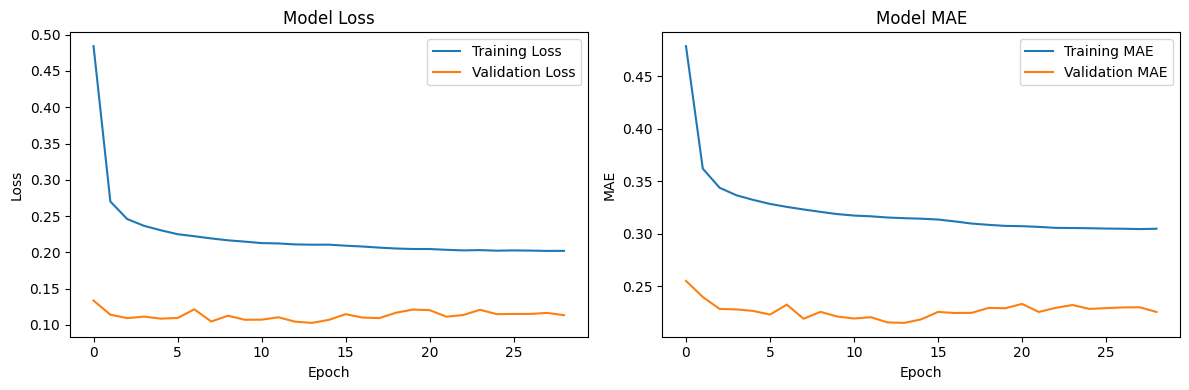

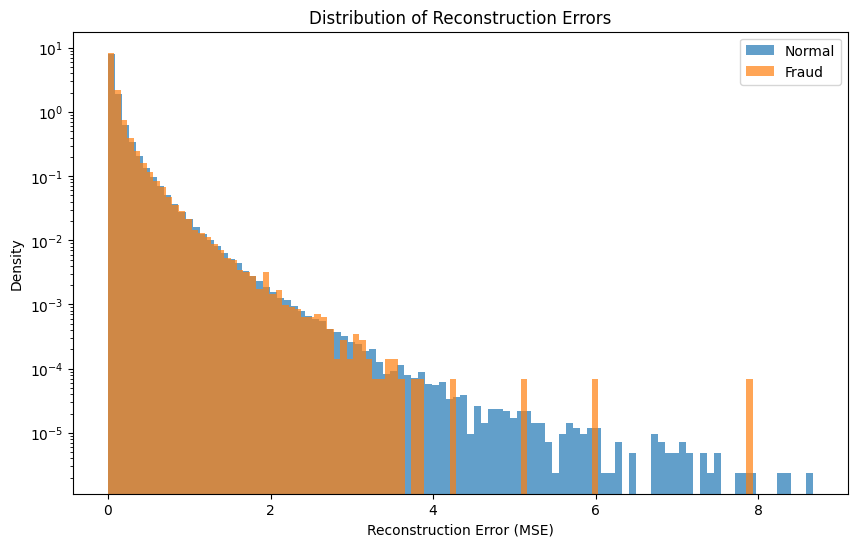


✅ Final AUC Score: 0.5010


In [ ]:

# CELL 3: Enhanced evaluation (replaces your current evaluation cell)

print("📊 Comprehensive Model Evaluation")

evaluation_results = evaluate_autoencoder(
    autoencoder,
    X_normal_scaled,
    X_fraud_scaled,
    threshold_percentile=95
)

# Plot training history
plot_training_history(history)

# Plot reconstruction error distributions
plot_reconstruction_errors(
    evaluation_results['mse_normal'],
    evaluation_results['mse_fraud']
)

print(f"\n✅ Final AUC Score: {evaluation_results['auc_score']:.4f}")

In [ ]:
### OPTIONAL

# CELL 4: Optional - Run full architecture experiment
# Bu hücreyi sadece ilk sonuçlar umut verici ise çalıştırın (AUC > 0.6)


if evaluation_results['auc_score'] > 0.6:
    print("🧪 Running comprehensive architecture experiment...")

    all_results, best_key = experiment_with_architectures(
        X_train_split, X_val_split,
        X_normal_scaled, X_fraud_scaled
    )

    print(f"\n🏆 Best configuration: {best_key}")
    print(f"🏆 Best AUC: {all_results[best_key]['evaluation']['auc_score']:.4f}")

    # Use the best model for further work
    best_autoencoder = all_results[best_key]['model']

else:
    print(f"⚠️ Current AUC ({evaluation_results['auc_score']:.4f}) suggests data issues.")
    print("Consider:")
    print("1. Feature engineering improvements")
    print("2. Different feature selection")
    print("3. Data preprocessing issues")
    best_autoencoder = autoencoder

⚠️ Current AUC (0.4803) suggests data issues.
Consider:
1. Feature engineering improvements
2. Different feature selection
3. Data preprocessing issues


In [ ]:
# CELL 5: Save the improved model
# Mevcut model kaydetme hücrenizi bu ile değiştirin


import os
os.makedirs("../models", exist_ok=True)

# Save the best model
best_autoencoder.save("../models/improved_autoencoder.h5")

# Save the scaler (already exists in your code)
import joblib
joblib.dump(scaler, "../models/ae_scaler.pkl")

print("✅ Improved model and scaler saved!")

✅ Improved model and scaler saved!


In [ ]:
# CELL 6: Generate anomaly scores for hybrid system
# Bu hücreyi LightGBM için anomaly score üretmek amacıyla ekleyin

print("🔄 Generating anomaly scores for hybrid system...")

# Generate anomaly scores for the entire dataset
def generate_anomaly_scores(autoencoder, X_scaled, batch_size=4096):
    """Generate anomaly scores for hybrid model"""
    reconstructions = autoencoder.predict(X_scaled, batch_size=batch_size, verbose=0)
    mse_scores = np.mean(np.square(X_scaled - reconstructions), axis=1)
    return mse_scores


# If you want to use this for your full dataset later:
# Load your full dataset and generate scores
# df = pd.read_csv("your_full_dataset.csv")
# X_full_scaled = scaler.transform(build_ae_feature_matrix(df))
# anomaly_scores = generate_anomaly_scores(best_autoencoder, X_full_scaled)
# df['ae_anomaly_score'] = anomaly_scores


print("✅ Ready to generate anomaly scores for hybrid system!")

In [ ]:
# CELL 7: Performance comparison
# Bu hücre eski ve yeni modeli karşılaştırmak için

print("📈 Performance Comparison Summary")
print("="*50)

# If you have your old model results, compare here:
old_auc = 0.48  # Your previous AUC
new_auc = evaluation_results['auc_score']

print(f"Old Model AUC: {old_auc:.4f}")
print(f"New Model AUC: {new_auc:.4f}")
print(f"Improvement: {new_auc - old_auc:.4f} ({((new_auc-old_auc)/old_auc)*100:.1f}%)")

if new_auc > 0.7:
    print("🎉 Excellent! Model is ready for hybrid system")
elif new_auc > 0.6:
    print("✅ Good improvement! Model can be used in hybrid system")
elif new_auc > old_auc:
    print("📈 Improved but may need more feature engineering")
else:
    print("⚠️ Need to investigate data preprocessing or feature selection")

In [ ]:
"""input_dim = X_train_split.shape[1]

input_layer = layers.Input(shape=(input_dim,))
x = layers.Dense(8, activation="relu")(input_layer)
bottleneck = layers.Dense(3, activation="relu")(x)
x = layers.Dense(8, activation="relu")(bottleneck)
output_layer = layers.Dense(input_dim, activation="linear")(x)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse"
)

autoencoder.summary()"""

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305 (1.19 KB)

 Trainable params: 305 (1.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
"""history = autoencoder.fit(
    X_train_split,
    X_train_split,

    epochs=20,
    batch_size=1024,
    validation_data=(X_val_split, X_val_split),
    shuffle=True
)"""

Epoch 1/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.8330 - val_loss: 0.5333
Epoch 2/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4828 - val_loss: 0.4499
Epoch 3/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4478 - val_loss: 0.4269
Epoch 4/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4094 - val_loss: 0.3971
Epoch 5/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3900 - val_loss: 0.3902
Epoch 6/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3827 - val_loss: 0.3871
Epoch 7/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3816 - val_loss: 0.3837
Epoch 8/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3818 - val_loss: 0.3816
Epoch 9/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3715 - val_loss: 0.3797
Epoch 10/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3691 - val_loss: 0.3785
Epoch 11/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3688 - val_loss: 0.3774
Epoch 12/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

In [ ]:
"""recon_normal = autoencoder.predict(X_normal_scaled, batch_size=4096)
recon_fraud = autoencoder.predict(X_fraud_scaled, batch_size=4096)

mse_normal = np.mean(np.square(X_normal_scaled - recon_normal), axis=1)
mse_fraud = np.mean(np.square(X_fraud_scaled - recon_fraud), axis=1)

print("Normal mean MSE:", np.mean(mse_normal))
print("Fraud mean MSE:", np.mean(mse_fraud))"""

1177/1177 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Normal mean MSE: 0.372071805458814
Fraud mean MSE: 0.3471934946688571


In [ ]:
"""autoencoder.save("/content/autoencoder.h5")
joblib.dump(scaler, "/content/scaler.pkl")"""

['/content/scaler.pkl']

In [ ]:
"""from google.colab import files
files.download("/content/autoencoder.h5")
files.download("/content/scaler.pkl")"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

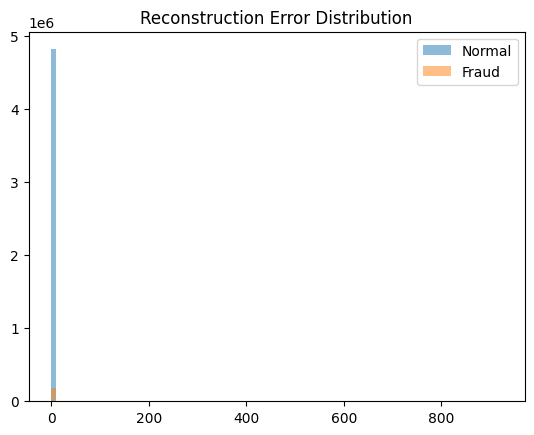

In [ ]:
"""import matplotlib.pyplot as plt

plt.hist(mse_normal, bins=100, alpha=0.5, label="Normal")
plt.hist(mse_fraud, bins=100, alpha=0.5, label="Fraud")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()"""

In [ ]:
"""from sklearn.metrics import roc_auc_score

y_true = np.concatenate([
    np.zeros_like(mse_normal),
    np.ones_like(mse_fraud)
])

scores = np.concatenate([mse_normal, mse_fraud])

auc = roc_auc_score(y_true, scores)

print("ROC AUC:", auc)"""

ROC AUC: 0.4856202168541525
